In [1]:
import numpy as np
#import tensorflow as tf
#import keras
#from keras import backend as K
#from keras.datasets import mnist
#from keras.models import Sequential, Model
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, Input
#from keras import activations
#import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from math import *
from itertools import chain

import import_ipynb
from Utils import *
from Model import *

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

importing Jupyter notebook from Utils.ipynb
cpu
(8.59, -302.24)
80
(-4.2, 347.8)
(9.54, -1151.36)
92903
27097
False
True
area final =  0.7741916666666666


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


[[0], [0], [1], [1], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [2], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0]]
341.0 26.0
324.5 357.5
9.5 42.5
importing Jupyter notebook from Model.ipynb
cpu


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [2]:
sigma_noise = [2, 2]
image_size = (400, 300)
nbr_inliers=300
nbr_outliers=200
nbr_outliers_range = (0, 800)
size_patch = (2, 2)


In [3]:
#input_dim = size_patch[0]*2+1
model = Weights().to(DEVICE)
model_old_loss = Weights().to(DEVICE)

model_patch = Weights2().to(DEVICE)

### Train model

In [4]:
def loss_func(y1, y2):
    n = len(y1[0])
    s = 0
    for k in range(n):
        print(y1[k][0], y2[k][0])
        s += abs(y1[k][0]-y2[k][0])
    return s

def train_model(model, image, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers_range, loss = 1, print_test=False):
    ((x_test, y_test, datas_test, lines_test, outliers_test), (x_train, y_train, datas_train, lines_train, outliers_train)) = split_training(generate_training_data(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers_range, loss = loss))
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-5))
    print("data generated")
    
    # Train step
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    #print(len(train_dl))
    
    valid_ds = TensorDataset(x_test, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model(xb)
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = sum(loss_fn(model(xb.to(DEVICE)), yb.to(DEVICE)) for xb, yb in valid_dl)
            m_test = sum(len(yb) for xb, yb in valid_dl)

        print("iteration = ", k+1, " ; loss_train = ", loss_train, " ; loss_eval = ", loss_eval.item())
        if print_test:
            plt.figure(1, figsize=(30, 10))
            test_index = np.random.randint(len(datas_test))
            plot_weights_during_training(model, image, datas_test[test_index], lines_test[test_index], outliers_test[test_index], size_patch)
            plt.show()
            plt.close()
        
        if k == epochs - 1:
            last_weight = model(x_test.to(DEVICE))
            print(last_weight)
            print(y_test)
            print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))
            

def train_model_patch(model, image, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers_range, size_patch, print_test=False):
    ((x_test, y_test, datas_test, lines_test, outliers_test), (x_train, y_train, datas_train, lines_train, outliers_train)) = split_training_bis(generate_training_data_patch(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers_range, size_patch))
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-6))
    print("data generated")
    
    # Train step
    x_train1, x_train2, x_train3 = x_train
    train_ds = TensorDataset(x_train1, x_train2, x_train3, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    #print(len(train_dl))
    
    x_test1, x_test2, x_test3 = x_test
    valid_ds = TensorDataset(x_test1, x_test2, x_test3, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb1, xb2, xb3, yb in train_dl:
            xb1, xb2, xb3, yb = xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float(), yb.to(DEVICE).float()
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model((xb1, xb2, xb3))
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = 0
            m_test = 0
            for xb1, xb2, xb3, yb in valid_dl:
                predict_test = model((xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float()))
                loss_eval += loss_fn(predict_test, yb.to(DEVICE).float())
                m_test += len(yb)

        print("iteration = ", k+1, " ; loss_train = ", loss_train, " ; loss_eval = ", loss_eval.item())
        if print_test:
            plt.figure(1, figsize=(30, 10))
            test_index = np.random.randint(len(datas_test))
            plot_weights_during_training_patch(model, image, datas_test[test_index], lines_test[test_index], outliers_test[test_index], size_patch)
            plt.show()
            plt.close()
        
        if k == epochs - 1:
            last_weight = model((x_test1.to(DEVICE).float(), x_test2.to(DEVICE).float(), x_test3.to(DEVICE).float()))
            print(last_weight)
            print(y_test)
            print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))




In [8]:
def train_model_multi_lines(model, image, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers_range, nbr_lines_range=(1, 1), print_test=False):
    ((x_test, y_test, datas_test, lines_test, outliers_test, index_test), (x_train, y_train, datas_train, lines_train, outliers_train, index_train)) = split_training_multi(generate_training_data_multi_lines(image, sigma, nbr, nbr_per_line, nbr_lines_range, nbr_inliers, nbr_outliers_range))
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-5))
    print("data generated")
    
    # Train step
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    #print(len(train_dl))
    
    valid_ds = TensorDataset(x_test, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model(xb)
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = sum(loss_fn(model(xb.to(DEVICE)), yb.to(DEVICE)) for xb, yb in valid_dl)
            m_test = sum(len(yb) for xb, yb in valid_dl)

        print("iteration = ", k+1, " ; loss_train = ", loss_train, " ; loss_eval = ", loss_eval.item())
        if print_test and k%10==0:
            plt.figure(1, figsize=(30, 10))
            test_index = np.random.randint(len(datas_test))
            plot_weights_during_training_multi_lines(model, image, datas_test[test_index], lines_test[test_index], index_test[test_index])
            plt.show()
            plt.close()
        
        if k == epochs - 1:
            last_weight = model(x_test.to(DEVICE))
            print(last_weight)
            print(y_test)
            print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))

data generated
iteration =  1  ; loss_train =  6.03636609017849  ; loss_eval =  0.12105739861726761
lines ref =  [(6.25, -1265.75), (-5.97, 1400.82)]
first point =  (212, 146)
(180, 0) (4.56, -820.7199999999999) 0.7142597479383972
(190, 0) (6.63, -1259.56) 1.8998358421898442
(200, 0) (12.16, -2431.92) 0.8432287836851644
(210, 0) (73.0, -15330.0) 0.33748501620115623
(220, 0) (-18.25, 4015.0) 1.3283791396814197
(229, 0) (-8.58, 1964.96) 5.314599990051071
(240, 0) (-5.21, 1250.52) 0.7760601678200459
(180, 10) (4.25, -755.0) 0.5518524437234927
(190, 10) (6.18, -1164.1599999999999) 1.7667550928313769
(200, 10) (11.33, -2255.96) 0.9394406185942829
(210, 10) (68.0, -14270.0) 0.3324580037454583
(220, 10) (-17.0, 3750.0) 1.4822654753368059
(229, 10) (-8.0, 1842.0) 4.64300936877968
(240, 10) (-4.85, 1174.1999999999998) 0.5860005620785235
(180, 20) (3.93, -687.1600000000001) 0.4160689576548409
(190, 20) (5.72, -1066.6399999999999) 1.5069694382104604
(200, 20) (10.5, -2080.0) 1.0647347137604406
(2

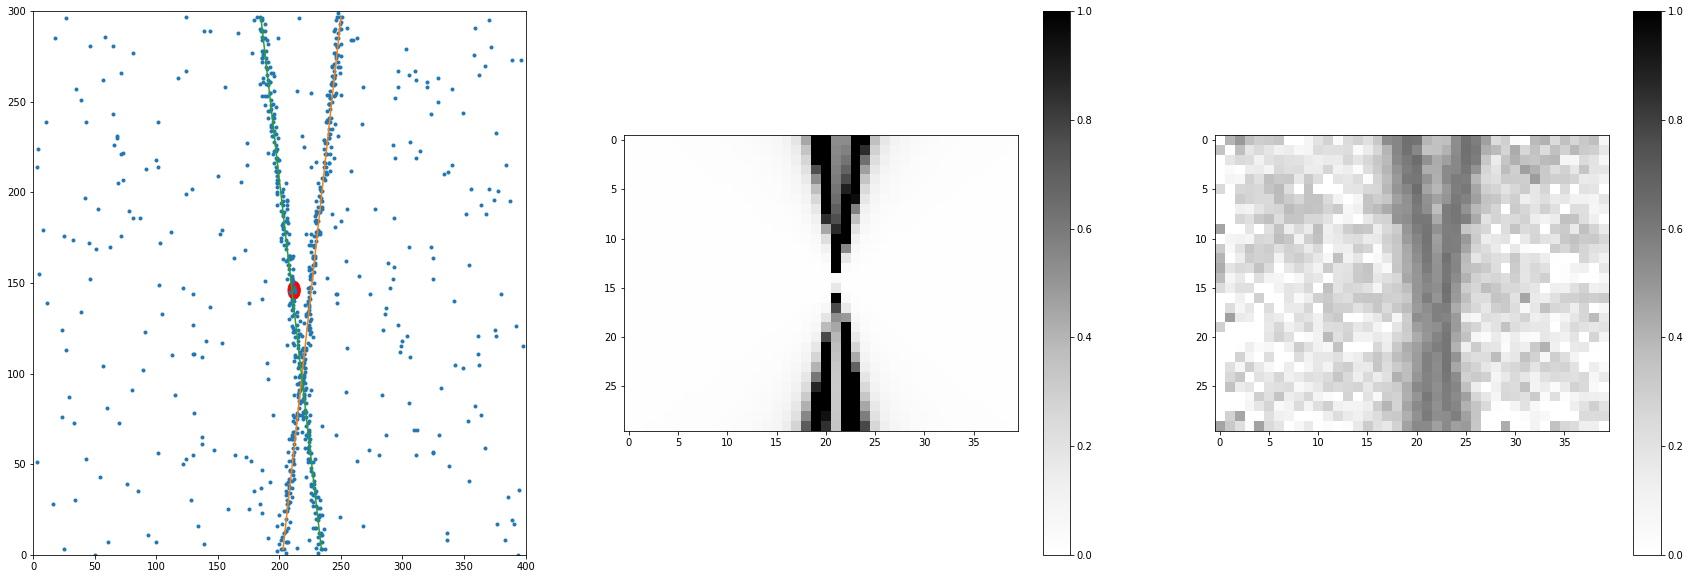

iteration =  2  ; loss_train =  6.018817514181137  ; loss_eval =  0.11900775134563446
iteration =  3  ; loss_train =  5.920785680413246  ; loss_eval =  0.1173919290304184
iteration =  4  ; loss_train =  5.913162052631378  ; loss_eval =  0.12110165506601334
iteration =  5  ; loss_train =  5.856861084699631  ; loss_eval =  0.12148799747228622
iteration =  6  ; loss_train =  5.83898788690567  ; loss_eval =  0.12118834257125854
iteration =  7  ; loss_train =  5.851109102368355  ; loss_eval =  0.12074894458055496
iteration =  8  ; loss_train =  5.750515550374985  ; loss_eval =  0.1193971261382103
iteration =  9  ; loss_train =  5.698149159550667  ; loss_eval =  0.11811777949333191
iteration =  10  ; loss_train =  5.787831544876099  ; loss_eval =  0.11899245530366898
iteration =  11  ; loss_train =  5.661217033863068  ; loss_eval =  0.11714866012334824
lines ref =  [(6.09, 168.1), (-4.14, 1022.4599999999999)]
first point =  (0, 174)
(0, 0) (1000, 174) 1.3254975629406371
(10, 0) (-17.39, 174.

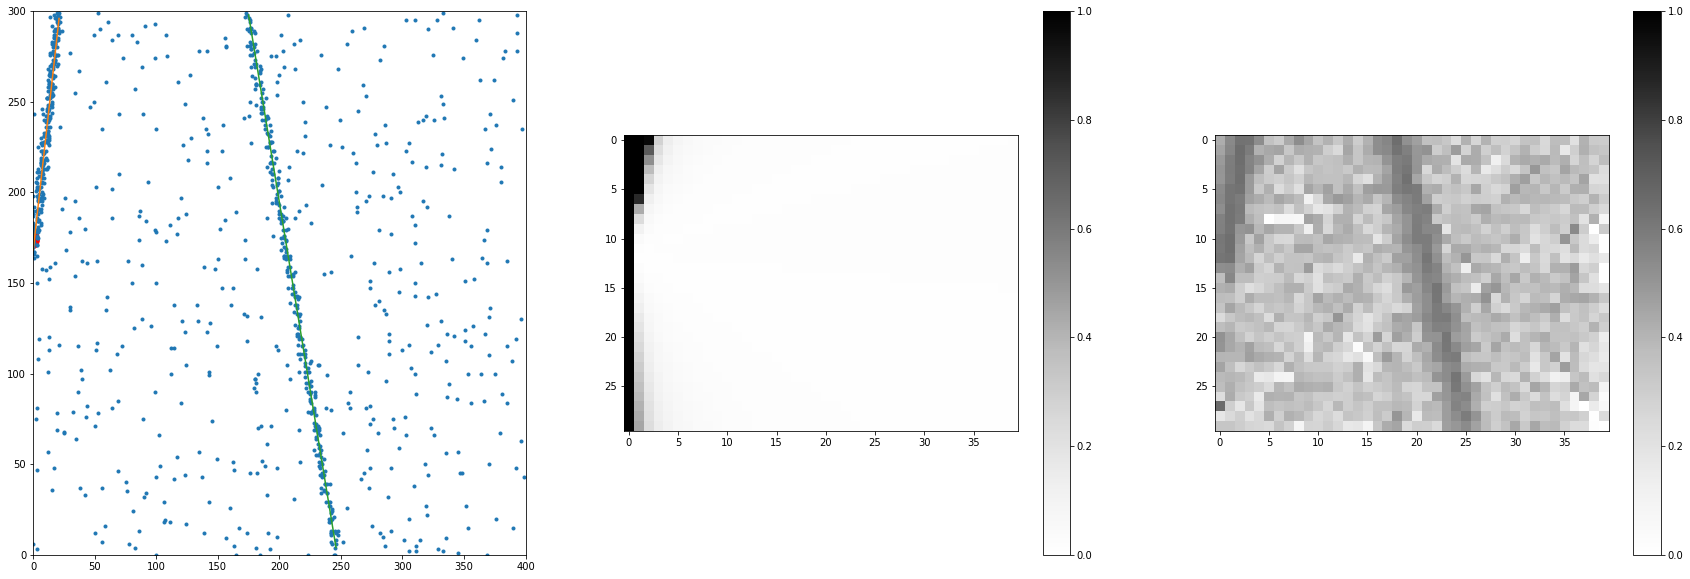

iteration =  12  ; loss_train =  5.62995719909668  ; loss_eval =  0.120635986328125
iteration =  13  ; loss_train =  5.553649067878723  ; loss_eval =  0.12101814150810242
iteration =  14  ; loss_train =  5.641902804374695  ; loss_eval =  0.11966745555400848
iteration =  15  ; loss_train =  5.542516604065895  ; loss_eval =  0.12268959730863571
iteration =  16  ; loss_train =  5.5692212879657745  ; loss_eval =  0.12245094776153564
iteration =  17  ; loss_train =  5.320062756538391  ; loss_eval =  0.12177358567714691
iteration =  18  ; loss_train =  5.412915885448456  ; loss_eval =  0.12386635690927505
iteration =  19  ; loss_train =  5.383085317909718  ; loss_eval =  0.12233667820692062
iteration =  20  ; loss_train =  5.292002081871033  ; loss_eval =  0.12348207831382751
iteration =  21  ; loss_train =  5.365598797798157  ; loss_eval =  0.12507420778274536
lines ref =  [(-3.13, 731.0699999999999), (-7.32, 1994.48)]
first point =  (227, 296)
(270, 0) (-6.88, 1857.76) 0.4223538754981331
(

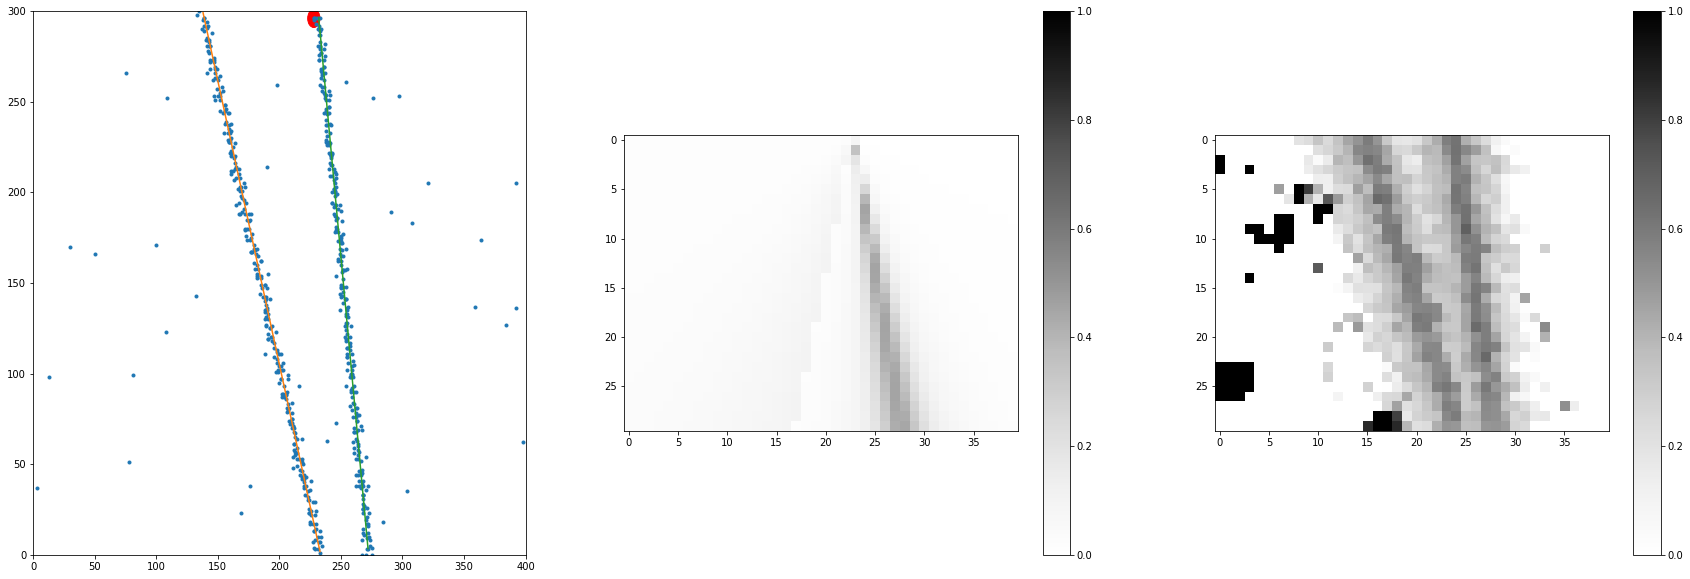

iteration =  22  ; loss_train =  5.291476294398308  ; loss_eval =  0.12691085040569305
iteration =  23  ; loss_train =  5.30535115301609  ; loss_eval =  0.12615087628364563
iteration =  24  ; loss_train =  5.235952645540237  ; loss_eval =  0.12597911059856415
iteration =  25  ; loss_train =  4.968906298279762  ; loss_eval =  0.1284884214401245
iteration =  26  ; loss_train =  5.332073822617531  ; loss_eval =  0.13238438963890076
iteration =  27  ; loss_train =  4.998865038156509  ; loss_eval =  0.13409443199634552
iteration =  28  ; loss_train =  5.085815027356148  ; loss_eval =  0.13576442003250122
iteration =  29  ; loss_train =  5.06340965628624  ; loss_eval =  0.13336580991744995
iteration =  30  ; loss_train =  4.859963685274124  ; loss_eval =  0.13459983468055725
iteration =  31  ; loss_train =  5.054942727088928  ; loss_eval =  0.13297337293624878
lines ref =  [(6.09, 168.1), (-4.14, 1022.4599999999999)]
first point =  (301, 8)


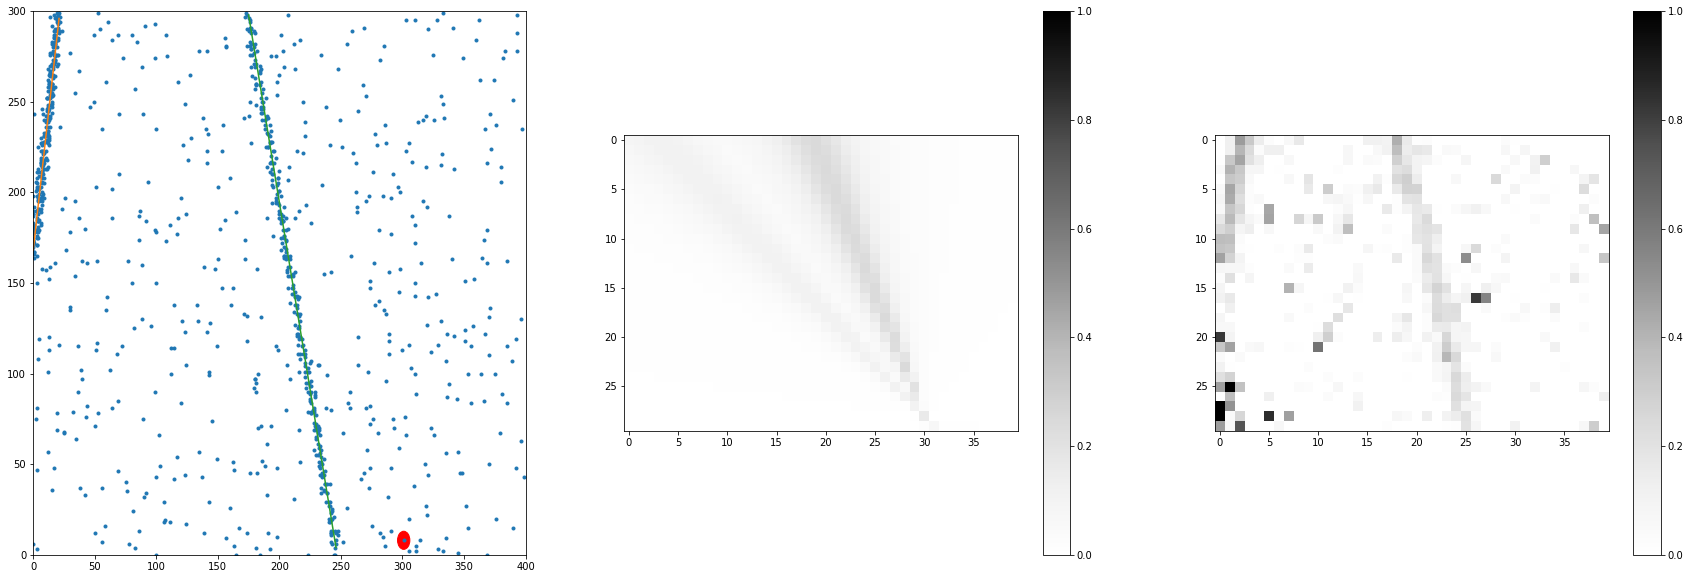

iteration =  32  ; loss_train =  4.72348216176033  ; loss_eval =  0.13080251216888428
iteration =  33  ; loss_train =  4.938379108905792  ; loss_eval =  0.13150210678577423
iteration =  34  ; loss_train =  4.75344917178154  ; loss_eval =  0.1339525431394577
iteration =  35  ; loss_train =  4.71947255730629  ; loss_eval =  0.13238370418548584
iteration =  36  ; loss_train =  4.55442002415657  ; loss_eval =  0.13445526361465454
iteration =  37  ; loss_train =  4.618021175265312  ; loss_eval =  0.1407117247581482
iteration =  38  ; loss_train =  4.848583787679672  ; loss_eval =  0.14312753081321716
iteration =  39  ; loss_train =  4.6240246295928955  ; loss_eval =  0.15093854069709778
iteration =  40  ; loss_train =  4.533423140645027  ; loss_eval =  0.14911095798015594
iteration =  41  ; loss_train =  4.586041733622551  ; loss_eval =  0.15186919271945953
lines ref =  [(-3.13, 731.0699999999999), (-7.32, 1994.48)]
first point =  (227, 296)
(270, 0) (-6.88, 1857.76) 0.4223538754981331
(280

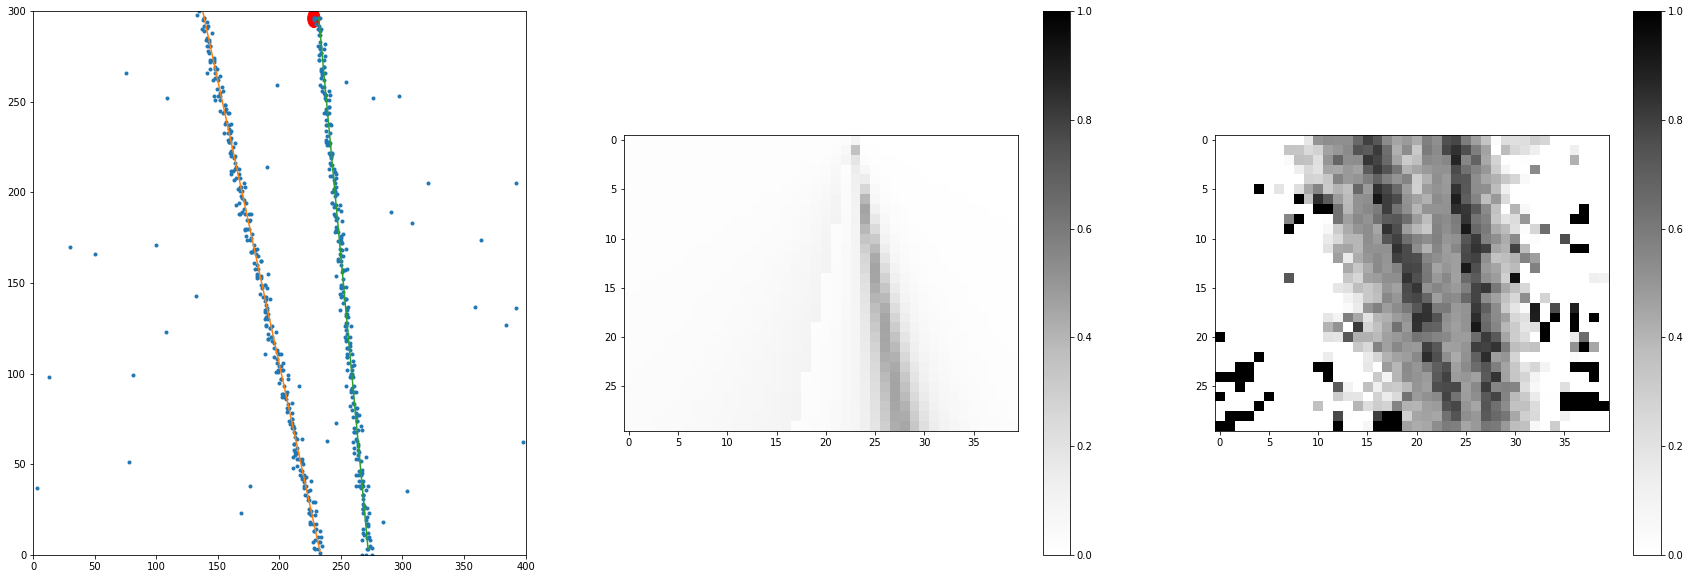

iteration =  42  ; loss_train =  4.672293603420258  ; loss_eval =  0.15939627587795258
iteration =  43  ; loss_train =  4.589650169014931  ; loss_eval =  0.1507292538881302
iteration =  44  ; loss_train =  4.661607563495636  ; loss_eval =  0.15125423669815063
iteration =  45  ; loss_train =  4.424402669072151  ; loss_eval =  0.14986838400363922
iteration =  46  ; loss_train =  4.416669264435768  ; loss_eval =  0.1404201239347458
iteration =  47  ; loss_train =  4.344566434621811  ; loss_eval =  0.14248178899288177
iteration =  48  ; loss_train =  4.6260232627391815  ; loss_eval =  0.14201128482818604
iteration =  49  ; loss_train =  4.421790421009064  ; loss_eval =  0.14646275341510773
iteration =  50  ; loss_train =  3.9674185663461685  ; loss_eval =  0.14807981252670288
iteration =  51  ; loss_train =  4.3061508461833  ; loss_eval =  0.14347359538078308
lines ref =  [(-7.55, 1953.45), (4.97, -1377.4599999999998)]
first point =  (336, 299)
(240, 0) (3.11, -745.96) 0.39975270837789906


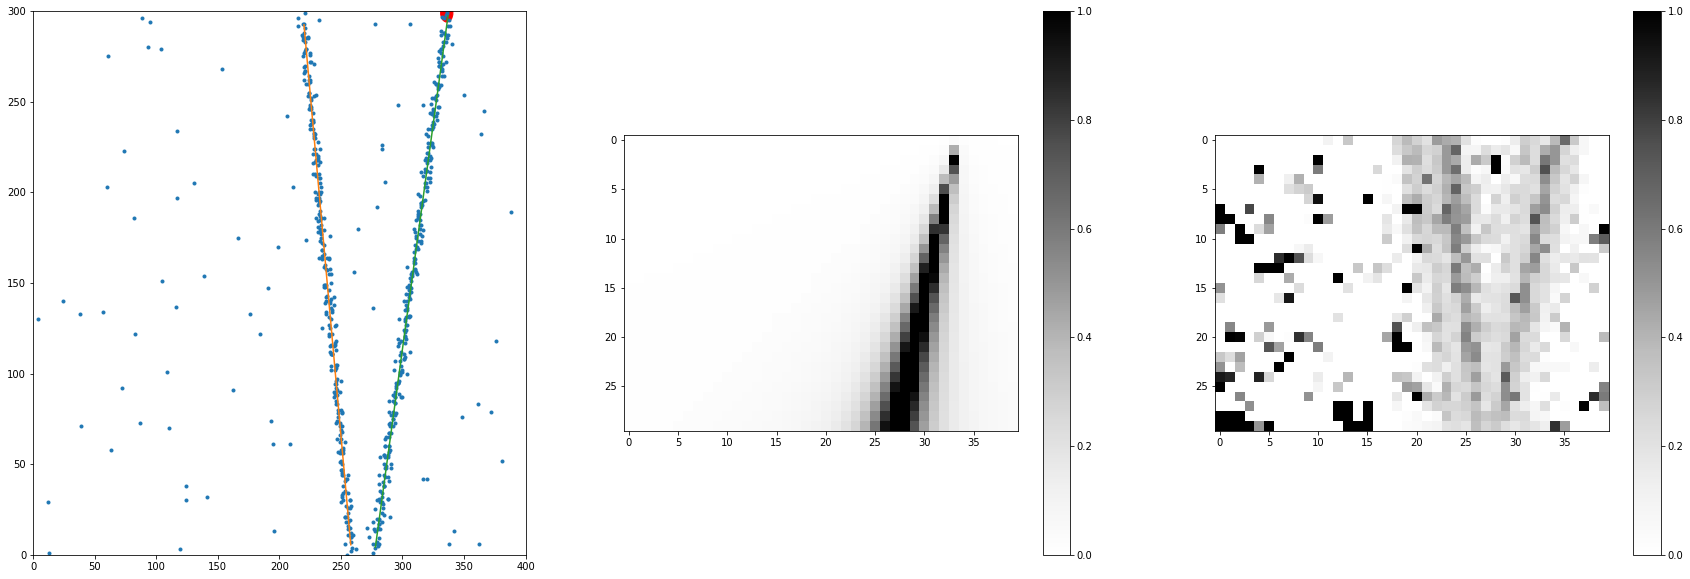

iteration =  52  ; loss_train =  4.734789609909058  ; loss_eval =  0.14193524420261383
iteration =  53  ; loss_train =  4.411500796675682  ; loss_eval =  0.1465279757976532
iteration =  54  ; loss_train =  4.274979338049889  ; loss_eval =  0.14594292640686035
iteration =  55  ; loss_train =  4.2867714911699295  ; loss_eval =  0.14408521354198456
iteration =  56  ; loss_train =  4.282462105154991  ; loss_eval =  0.1487053483724594
iteration =  57  ; loss_train =  4.228115096688271  ; loss_eval =  0.14607305824756622
iteration =  58  ; loss_train =  4.248021677136421  ; loss_eval =  0.1434706598520279
iteration =  59  ; loss_train =  4.330253392457962  ; loss_eval =  0.14530472457408905
iteration =  60  ; loss_train =  4.153142735362053  ; loss_eval =  0.14424419403076172
iteration =  61  ; loss_train =  4.392816290259361  ; loss_eval =  0.14543011784553528
lines ref =  [(-3.13, 731.0699999999999), (-7.32, 1994.48)]
first point =  (167, 188)
(180, 0) (-14.46, 2602.82) 0.3898588991165109


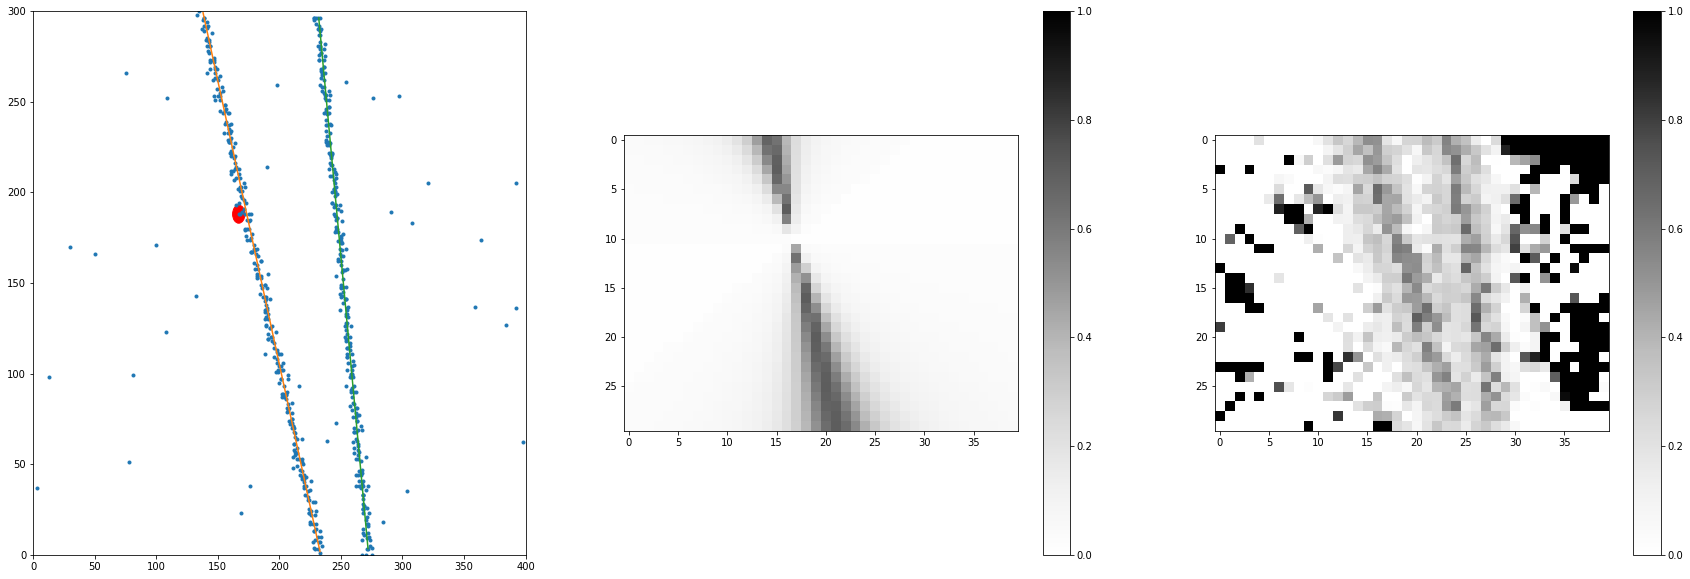

iteration =  62  ; loss_train =  4.155617401003838  ; loss_eval =  0.14404185116291046
iteration =  63  ; loss_train =  4.444256961345673  ; loss_eval =  0.1370188444852829
iteration =  64  ; loss_train =  4.211087584495544  ; loss_eval =  0.1397157907485962
iteration =  65  ; loss_train =  4.032632157206535  ; loss_eval =  0.1411667764186859
iteration =  66  ; loss_train =  4.594144433736801  ; loss_eval =  0.15067058801651
iteration =  67  ; loss_train =  4.135710418224335  ; loss_eval =  0.1406240314245224
iteration =  68  ; loss_train =  4.0011487901210785  ; loss_eval =  0.14258603751659393
iteration =  69  ; loss_train =  4.188895717263222  ; loss_eval =  0.15035559237003326
iteration =  70  ; loss_train =  3.895757094025612  ; loss_eval =  0.14469900727272034
iteration =  71  ; loss_train =  3.825336530804634  ; loss_eval =  0.14363227784633636
lines ref =  [(2.63, -116.13999999999999), (6.31, -2284.21)]
first point =  (19, 251)


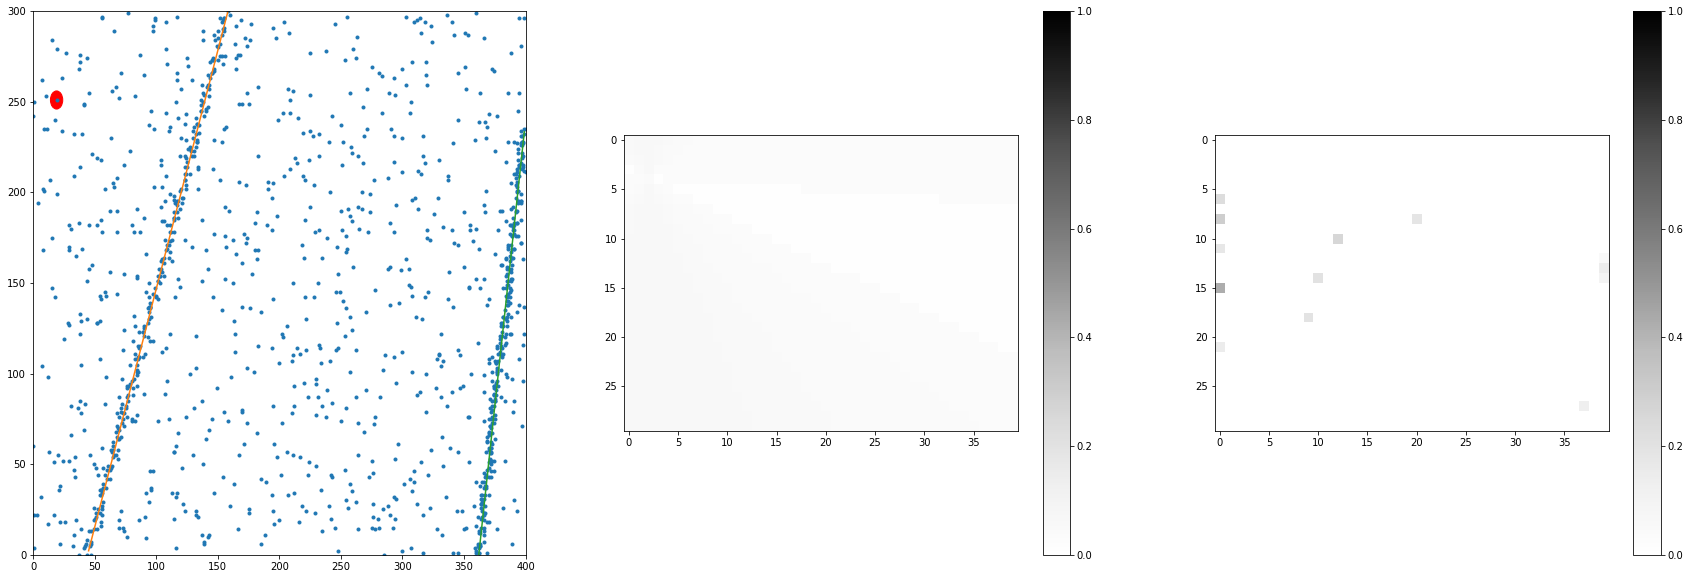

iteration =  72  ; loss_train =  4.069930776953697  ; loss_eval =  0.1508404016494751
iteration =  73  ; loss_train =  3.900545686483383  ; loss_eval =  0.15352851152420044
iteration =  74  ; loss_train =  4.1760279685258865  ; loss_eval =  0.15204373002052307
iteration =  75  ; loss_train =  3.9868614077568054  ; loss_eval =  0.14919620752334595
iteration =  76  ; loss_train =  3.892716094851494  ; loss_eval =  0.1427176147699356
iteration =  77  ; loss_train =  3.9595336616039276  ; loss_eval =  0.13969072699546814
iteration =  78  ; loss_train =  3.957223802804947  ; loss_eval =  0.1458924561738968
iteration =  79  ; loss_train =  4.173084884881973  ; loss_eval =  0.15751290321350098
iteration =  80  ; loss_train =  3.8451332300901413  ; loss_eval =  0.15913434326648712
iteration =  81  ; loss_train =  3.9853760600090027  ; loss_eval =  0.15485788881778717
lines ref =  [(6.83, -291.46), (3.68, -1211.28)]
first point =  (59, 116)
(40, 0) (6.1, -243.89999999999998) 0.7071636250325941


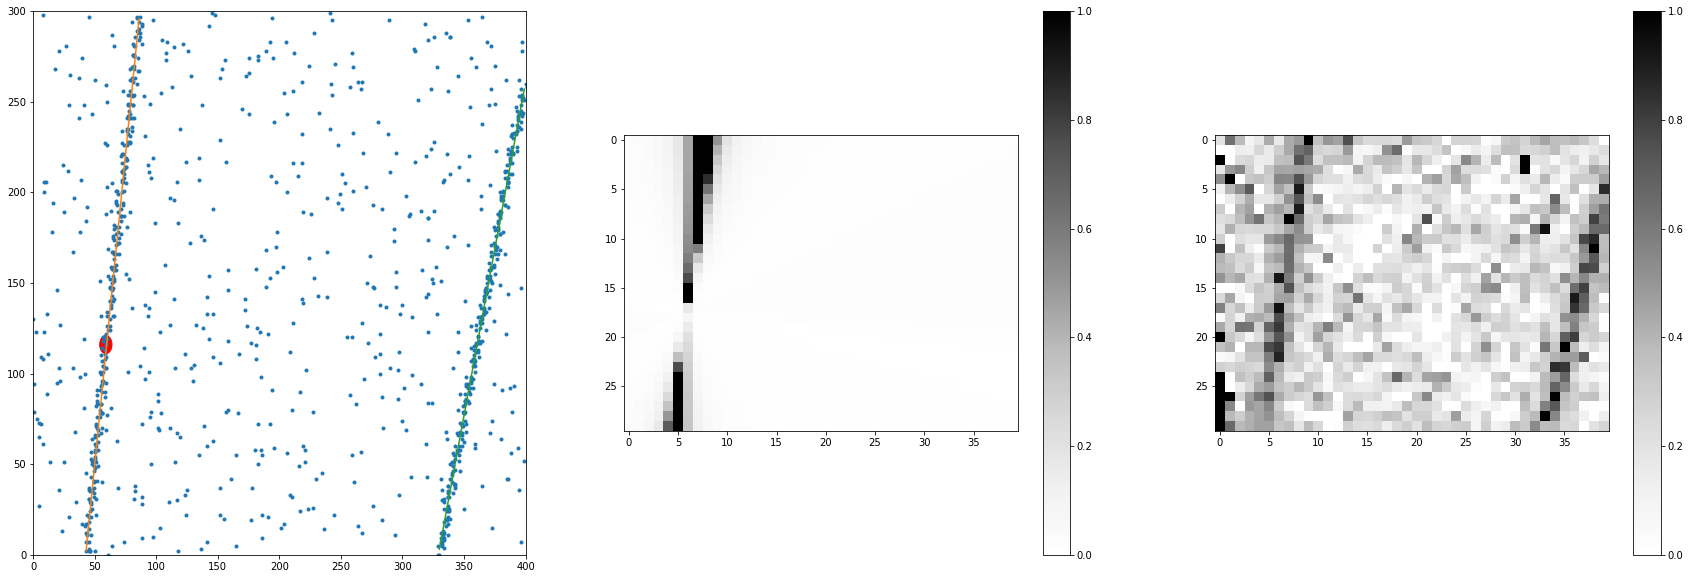

iteration =  82  ; loss_train =  4.000833421945572  ; loss_eval =  0.1572723686695099
iteration =  83  ; loss_train =  4.019729360938072  ; loss_eval =  0.1467205286026001
iteration =  84  ; loss_train =  3.7521672397851944  ; loss_eval =  0.14918316900730133
iteration =  85  ; loss_train =  3.9298555701971054  ; loss_eval =  0.15760783851146698
iteration =  86  ; loss_train =  3.834446594119072  ; loss_eval =  0.15824879705905914
iteration =  87  ; loss_train =  4.21127587556839  ; loss_eval =  0.15629738569259644
iteration =  88  ; loss_train =  3.5488192588090897  ; loss_eval =  0.16075272858142853
iteration =  89  ; loss_train =  3.6039889454841614  ; loss_eval =  0.1696438044309616
iteration =  90  ; loss_train =  3.6216511726379395  ; loss_eval =  0.17477144300937653
iteration =  91  ; loss_train =  3.901389852166176  ; loss_eval =  0.17044328153133392
lines ref =  [(6.09, 168.1), (-4.14, 1022.4599999999999)]
first point =  (338, 187)


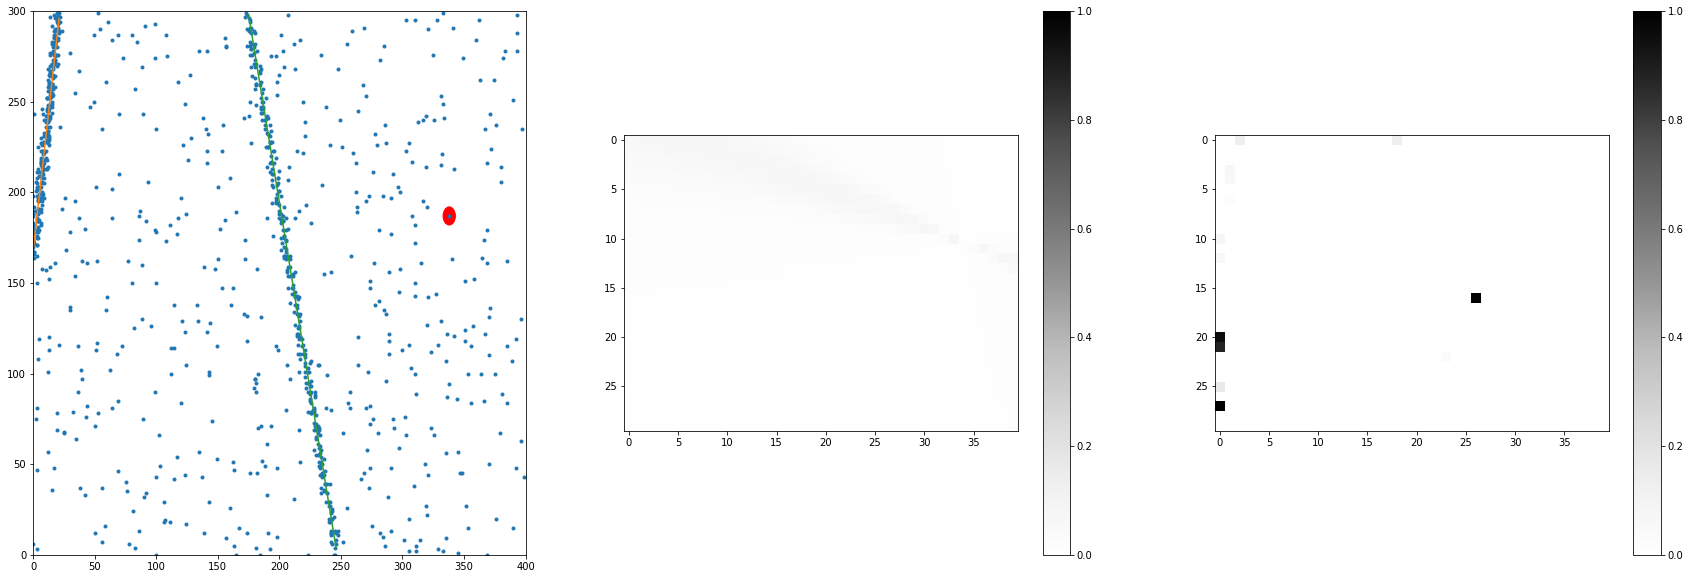

iteration =  92  ; loss_train =  3.8026275634765625  ; loss_eval =  0.19743305444717407
iteration =  93  ; loss_train =  3.4527792632579803  ; loss_eval =  0.21134543418884277
iteration =  94  ; loss_train =  3.9330827593803406  ; loss_eval =  0.20441293716430664
iteration =  95  ; loss_train =  3.6961196810007095  ; loss_eval =  0.19186581671237946
iteration =  96  ; loss_train =  3.256752073764801  ; loss_eval =  0.19192470610141754
iteration =  97  ; loss_train =  3.475461468100548  ; loss_eval =  0.20724348723888397
iteration =  98  ; loss_train =  3.319105178117752  ; loss_eval =  0.20731933414936066
iteration =  99  ; loss_train =  3.327713578939438  ; loss_eval =  0.19609352946281433
iteration =  100  ; loss_train =  3.2152311950922012  ; loss_eval =  0.19213031232357025
tensor([[0.0000],
        [0.2923],
        [0.0000],
        [0.2649],
        [0.0000],
        [0.0000],
        [0.2932],
        [0.2331],
        [0.0130],
        [0.0000],
        [0.3680],
        [0.22

In [9]:
train_model_multi_lines(model, image_size, sigma_noise, 10, 100, 100, 100, nbr_inliers, nbr_outliers_range, nbr_lines_range=(2, 2), print_test=True)

In [ ]:

train_model(model, image_size, sigma_noise, 10, 100, 10, 100, nbr_inliers, nbr_outliers_range, print_test=True)
#train_model(model_old_loss, image_size, sigma_noise, 30, 529, 100, 100, nbr_inliers, nbr_outliers, loss = 0)
#train_model_patch(model_patch, image_size, sigma_noise, 10, 100, 10, 100, nbr_inliers, nbr_outliers_range, size_patch, print_test=True)

### Test weights results

In [8]:
def test_weights_image(model1, model2, model3, image, sigma, nbr_inliers, nbr_outliers):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n_inliers_precise = len(data[0])-nbr_outliers
    dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
    n = len(data[0])
    print(n)
    index = 1
    
    for it in range(10):
        print("iteration = ", it)
        i1 = np.random.randint(n)
        scale = 10
        all_features_nn = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        all_features_patch1 = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        all_features_patch2 = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        all_features_patch3 = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        data[0].append(-1)
        data[1].append(-1)
        print(len(data[0]))
        p1 = (data[0][i1], data[1][i1])
        weights_ref = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        weights_ref_old = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        for y in range(0, image[1], scale):
            for x in range(0, image[0], scale):
                p2 = (x/image[0], y/image[0])
                data[0][-1] = float(x)/image[0]
                data[1][-1] = float(y)/image[1]
                #print(p1)
                #print(p2)
                
                feature_nn = compute_features_k(data, i1, n)
                all_features_nn[(image[1]-y-1)//scale][x//scale] = feature_nn
                feature1, feature2, feature3=compute_features_patch(data, i1, n, image, size_patch)
                all_features_patch1[(image[1]-y-1)//scale][x//scale] = feature1
                all_features_patch2[(image[1]-y-1)//scale][x//scale] = feature2
                all_features_patch3[(image[1]-y-1)//scale][x//scale] = feature3

                line = compute_line_from_points(p1, p2, image)
                area_old = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                weights_ref[(image[1]-y-1)//scale][x//scale] = area
                weights_ref_old[(image[1]-y-1)//scale][x//scale] = area_old
        
        del(data[0][n])
        del(data[1][n])
        print(len(data[0]))

        all_features_nn = list(chain.from_iterable(all_features_nn))
        all_features_patch1 = list(chain.from_iterable(all_features_patch1))
        all_features_patch2 = list(chain.from_iterable(all_features_patch2))
        all_features_patch3 = list(chain.from_iterable(all_features_patch3))
        
        model1.eval()
        model2.eval()
        model3.eval()
        with torch.no_grad():                
            X_tensor_nn = torch.Tensor(all_features_nn)
            weights1 = model1(X_tensor_nn.to(DEVICE))

            X_tensor_patch1 = torch.Tensor(all_features_patch1)
            X_tensor_patch2 = torch.Tensor(all_features_patch2)
            X_tensor_patch3 = torch.Tensor(all_features_patch3)
            weights2 = model2((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))

            weights3 = model3(X_tensor_nn.to(DEVICE))
 
        plot_first_point(data, line_ref, p1, image)
        plot_image(weights_ref_old, image, scale)
        plot_image(weights3.cpu(), image, scale)
        plot_image(weights_ref, image, scale)
        plot_image(weights1.cpu(), image, scale)
        plot_image(weights2.cpu(), image, scale)
        plt.show()

460
iteration =  0
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


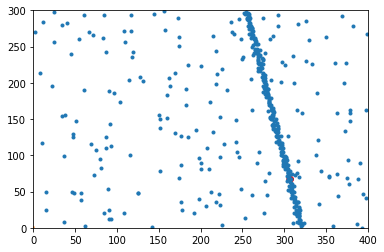

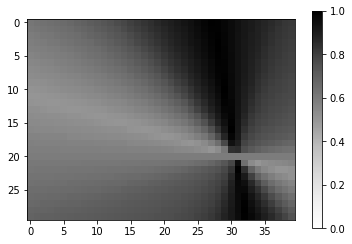

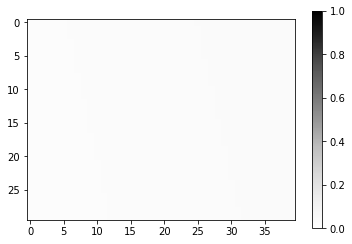

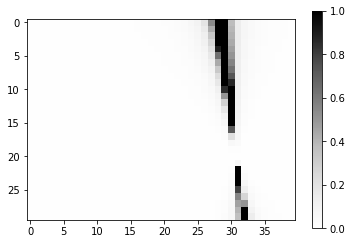

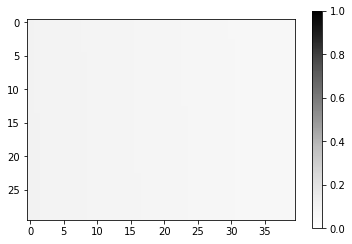

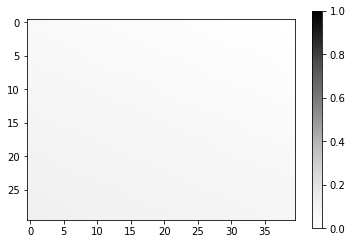

iteration =  1
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


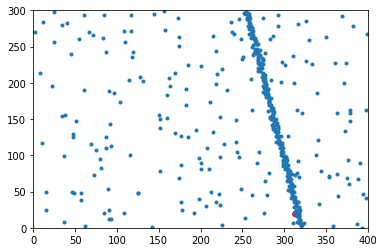

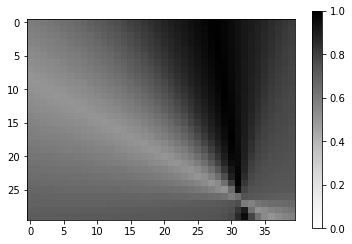

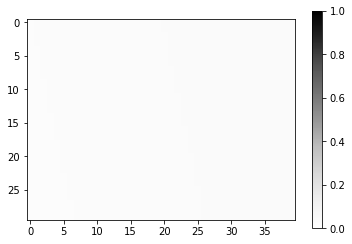

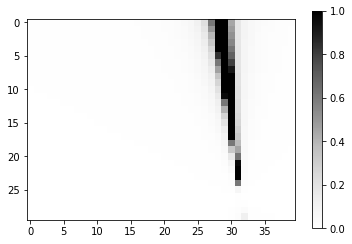

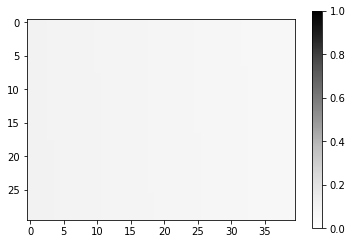

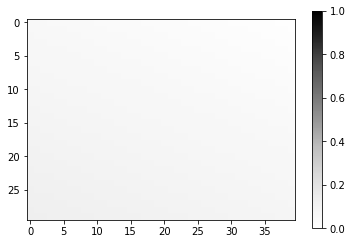

iteration =  2
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


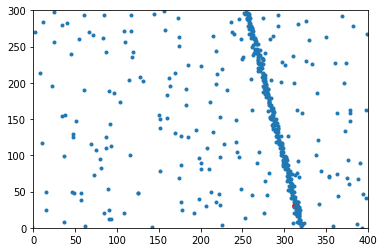

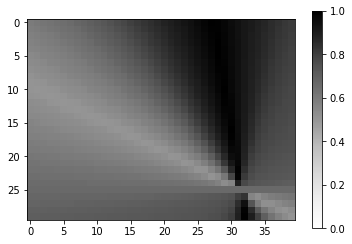

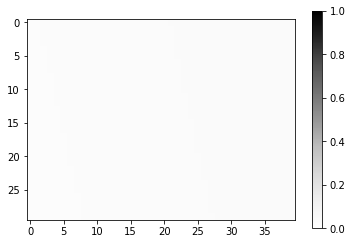

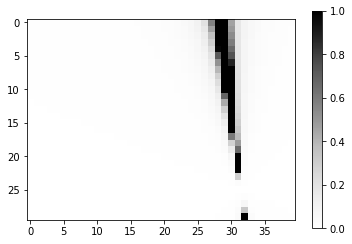

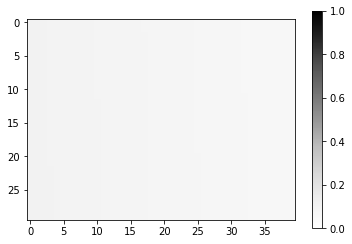

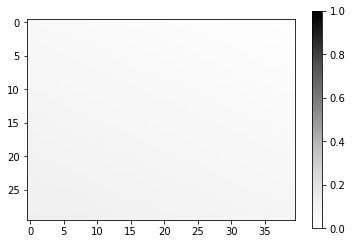

iteration =  3
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


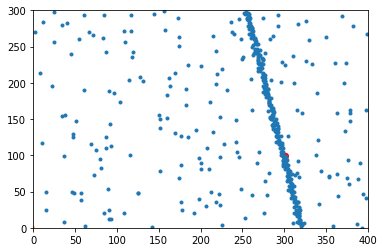

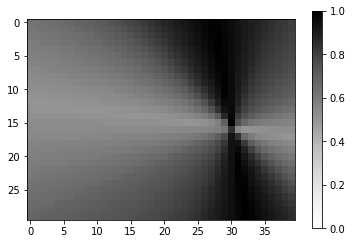

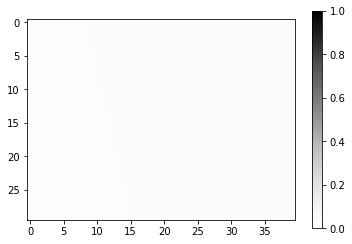

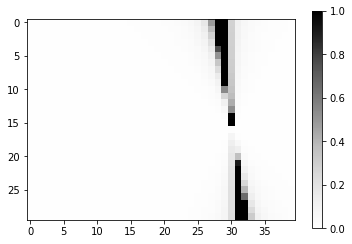

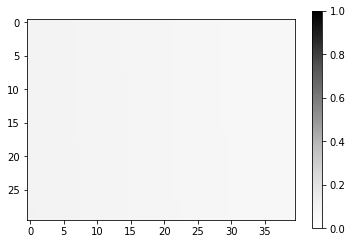

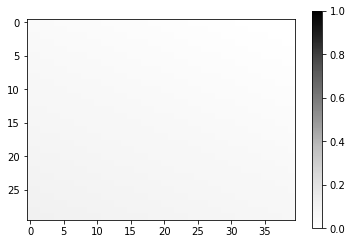

iteration =  4
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


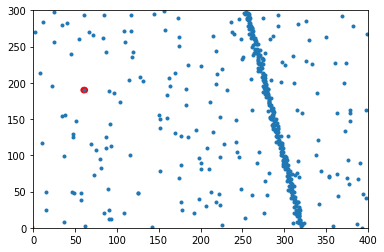

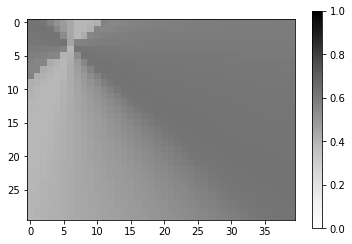

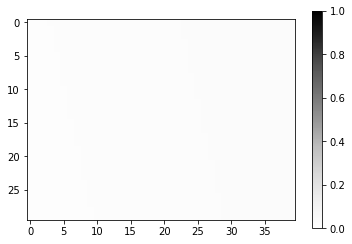

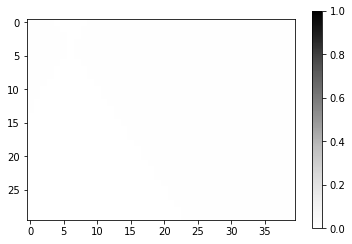

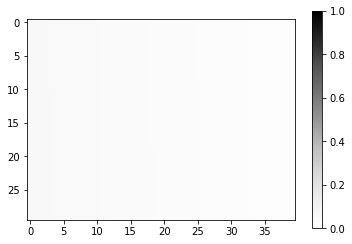

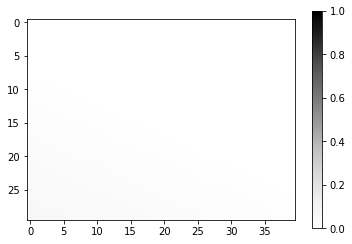

iteration =  5
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


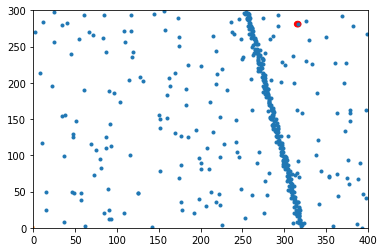

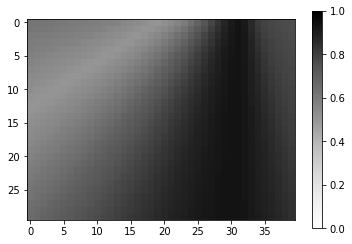

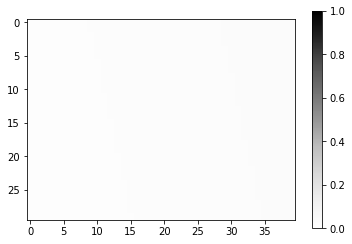

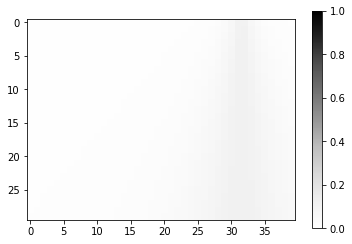

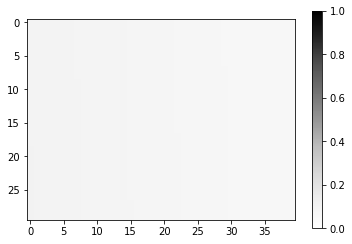

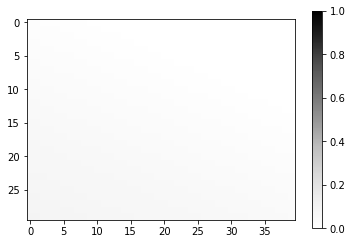

iteration =  6
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


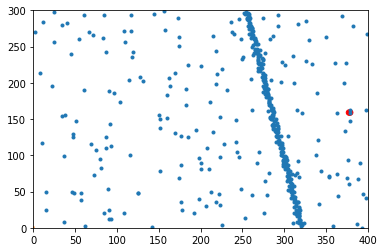

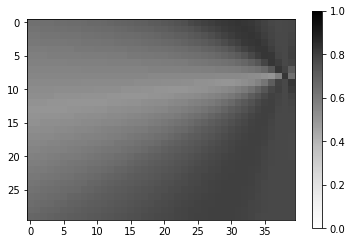

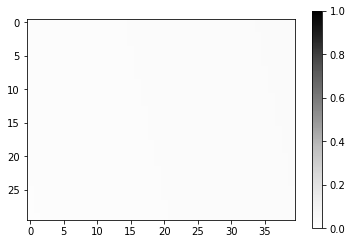

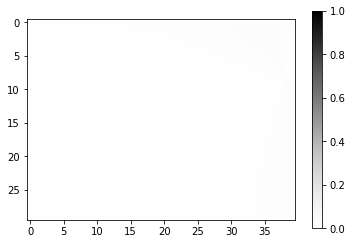

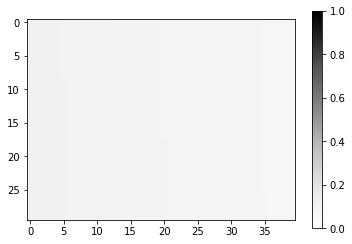

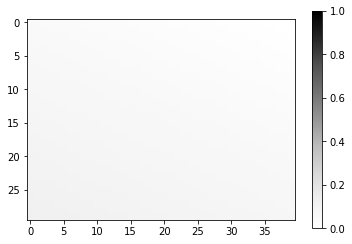

iteration =  7
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


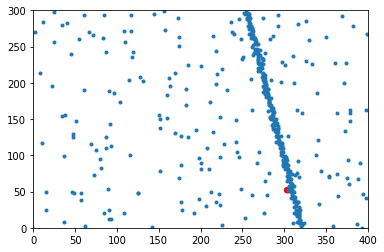

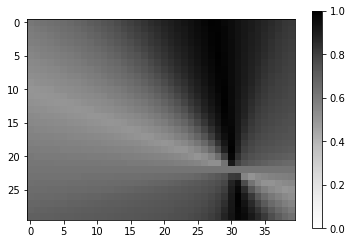

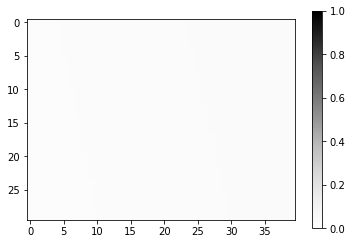

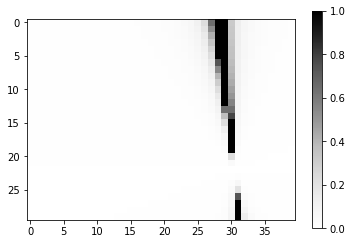

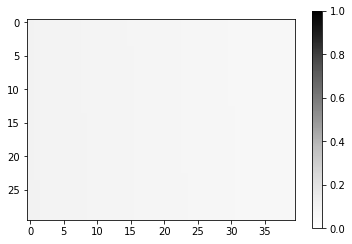

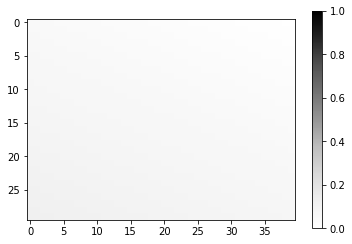

iteration =  8
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


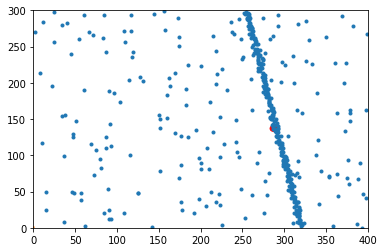

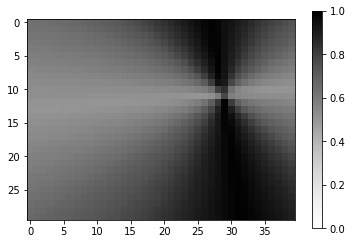

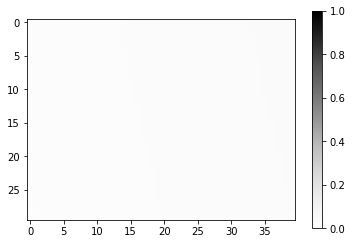

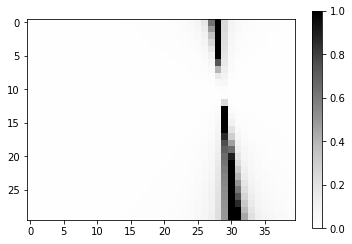

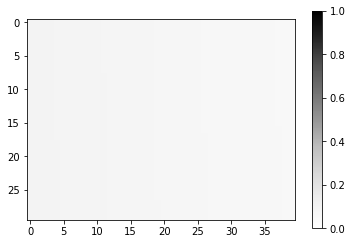

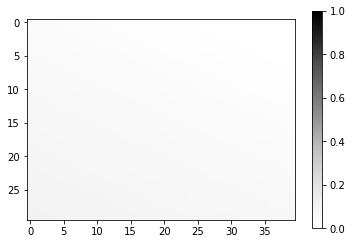

iteration =  9
461
460
(30, 40)
(30, 40)
(30, 40)
(30, 40)
(30, 40)


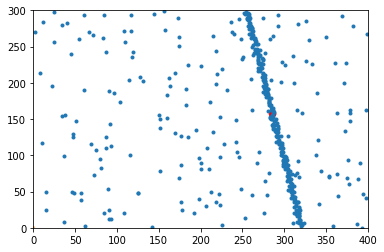

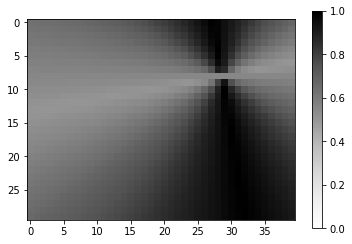

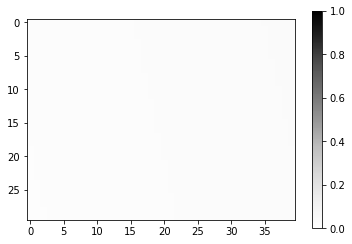

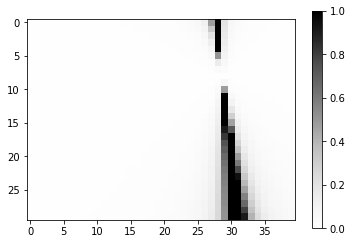

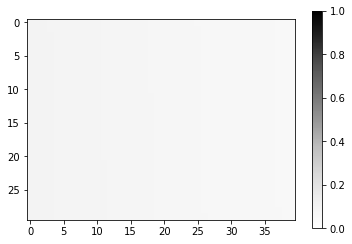

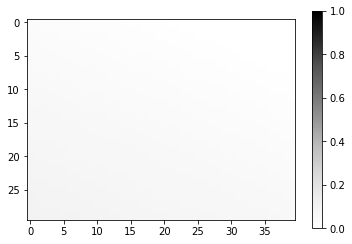

In [9]:
test_weights_image(model, model_patch, model_old_loss, image_size, sigma_noise, nbr_inliers, nbr_outliers)

In [6]:
def test_nn(model, image, sigma, nbr_inliers, nbr_outliers):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n_inliers_precise = len(data[0])-nbr_outliers
    dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
    n = len(data[0])

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    fig.show()
    
    
    for it in range(10):
        i1 = np.random.randint(n)
        X = []
        coord = []
        weights_ref = []
        p1 = (data[0][i1], data[1][i1])
        for i2 in range(n):
            if i2!=i1:
                feature=compute_features(data, i1, i2)
                X.append(feature)
                  
                
                p2 = (data[0][i2], data[1][i2])
                line = compute_line_from_points(p1, p2, image)
                #area = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                weights_ref.append([area])
                
                coord.append((data[0][i2], data[1][i2]))

        model.eval()
        with torch.no_grad():
            X_tensor = torch.Tensor(X)
            weights = model(X_tensor)
        
        #plot_weights(weights, coord, p1, image)
        plot_weights(weights_ref, coord, p1, image, ref=True)
        
def test_nn_compare(model1, model2, model3, image, sigma, nbr_inliers, nbr_outliers):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n_inliers_precise = len(data[0])-nbr_outliers
    dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
    n = len(data[0])

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    fig.show()
    
    
    for it in range(10):
        i1 = np.random.randint(n)
        X_nn = []
        X_nn_old = []
        X_patch1 = []
        X_patch2 = []
        X_patch3 = []
        coord = []
        weights_ref = []
        weights_ref_old = []
        p1 = (data[0][i1], data[1][i1])
        for i2 in range(n):
            if i2!=i1:
                feature_nn=compute_features_k(data, i1, i2)
                X_nn.append(feature_nn)
                
                feature1, feature2, feature3=compute_features_patch(data, i1, i2, image)
                X_patch1.append(feature1)
                X_patch2.append(feature2)
                X_patch3.append(feature3)
                  
                
                p2 = (data[0][i2], data[1][i2])
                line = compute_line_from_points(p1, p2, image)
                area_old = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                weights_ref.append([area])
                weights_ref_old.append([area_old])

                coord.append((data[0][i2], data[1][i2]))

        model.eval()
        with torch.no_grad():                
            X_tensor_nn = torch.Tensor(X_nn)
            weights1 = model1(X_tensor_nn.to(DEVICE))
            
            X_tensor_patch1 = torch.Tensor(X_patch1)
            X_tensor_patch2 = torch.Tensor(X_patch2)
            X_tensor_patch3 = torch.Tensor(X_patch3)
            weights2 = model2((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))
            
            weights3 = model3(X_tensor_nn.to(DEVICE))

        
        plot_weights(weights_ref_old, coord, p1, image)
        plot_weights(weights3, coord, p1, image)
        
        plot_weights(weights_ref, coord, p1, image)
        plot_weights(weights1, coord, p1, image)
        plot_weights(weights2, coord, p1, image)




In [ ]:
test_nn_compare(model, model_patch, model_old_loss, image_size, sigma_noise, nbr_inliers, nbr_outliers)

### Ransac

In [7]:
def get_inliers(data, line, threshold, image):
    a, b = line
    X, Y = data
    Inliers = [[], []]
    for i in range(len(X)):
        (x, y) = (X[i], Y[i])
        (xb, yb) = x*image[0], y*image[1]
        if abs((a*xb+b) - yb)/sqrt(1+a*a) < threshold:
            Inliers[0].append(x)
            Inliers[1].append(y)
    return Inliers

def get_first_point(method, data, image, densities):
    if method == 0:
        i1 = np.random.randint(len(data[0]))
    elif method == 1:
        n = len(data[0])
        i1 = sample_from_weights(data, densities)
        
    return i1
        

def get_model(model, model_type, data, image, type_loss, type_first_point, line_ref, densities):
    i1 = get_first_point(type_first_point, data, image, densities)
    if line_ref is None:
        weights = compute_weights(model, model_type, data, i1, image)
    else:
        weights = compute_weights_ref(line_ref, image, data, i1, type_loss)
    #print(mean_weights(weights))
    i2 = sample_from_weights(data, weights)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line


def update_stopping_criterion(k, inliers, proba, it_end):
    if k >= it_end:
        return True
    return False


def ransac(data, threshold, image, proba, type_first_point, type_loss, model_type = None, line_ref=None, model=None, compare=False, it_end=150, n_x=0.05, n_y=0.05):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    densities = get_density_vector(data, image, n_x, n_y)
    while not end:
        line = get_model(model, model_type, data, image, type_loss, type_first_point, line_ref, densities)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba, it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    if compare:
        return line_max, inliers_max, nbr_inliers
    return line_max, inliers_max

### Uniform Ransac


In [8]:
def get_model_uniform(data, image):
    n = len(data[0])
    i1 = np.random.randint(n)
    i2 = np.random.randint(n)
    while i1 == i2:
        i2 = np.random.randint(n)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line


def ransac_uniform(data, threshold, image, proba, it_end=150):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    while not end:
        line = get_model_uniform(data, image)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba, it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    return line_max, inliers_max, nbr_inliers

### Compare Ransacs

In [9]:
def compare_uniform(image, sigma, n_inliers, n_outliers, type_loss, model=None, model_type=None,average=5):
    Lines = []
    Datas = []
    for k in range(average):
        line = generate_line(image)
        data = generate_data(line, image, sigma, n_inliers, n_outliers)
        Lines.append(line)
        Datas.append(data)
    
    threshold = 5
    proba = 0.1
    
    it = 150
    nbr_inliers_sample = [0]*it
    nbr_inliers_uniform = [0]*it
    
    for k in range(average):
        print(k)
        line_predict1, inliers1, nbr_inliers1 = ransac(Datas[k], threshold, image, proba, 0, type_loss, model_type=model_type, line_ref=Lines[k], model=model, compare=True, it_end=it)
        line_predict2, inliers2, nbr_inliers2 = ransac_uniform(Datas[k], threshold, image, proba, it_end=it)
        plot_lines(Datas[k], line_predict1, line_predict2, image)
        
        for j in range(it):
            nbr_inliers_sample[j] += nbr_inliers1[j]
            nbr_inliers_uniform[j] += nbr_inliers2[j]
    
    for j in range(it):
        nbr_inliers_sample[j] /=average
        nbr_inliers_uniform[j] /= average
        
    fig, ax = plt.subplots()
    ax.plot(nbr_inliers_sample, c='g')
    ax.plot(nbr_inliers_uniform, c='r')
    fig.show()
    
    print("done")

def compare_all_ransac(image, sigma, models, n_inliers, n_outliers, average=5):
    Lines = []
    Datas = []
    for k in range(average):
        line = generate_line(image)
        data = generate_data(line, image, sigma, n_inliers, n_outliers)
        Lines.append(line)
        Datas.append(data)
    
    threshold = 5
    proba = 0.1
    
    it = 150
    n_types = len(models)
    nbr_inliers_all = [[0]*it for _ in range(n_types+1)]
    colors = ['black', 'green', 'red', 'yellow', 'orange', 'blue']
    
    for k in range(average):
        print(k)
        fig, ax = plt.subplots()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        data = Datas[k]
        plot_data(data, ax)
        for j in range(n_types):
            (model, model_type, type_loss, first_point, ref) = models[j]
            if ref:
                line_ref=Lines[k]
            else:
                line_ref=None
            line_predict, inliers, nbr_inliers = ransac(data, threshold, image, proba, first_point, type_loss, model_type = model_type, line_ref=line_ref, model=model, compare=True, it_end=it)
            plot_line(line_predict, image, ax, c=colors[j%len(colors)])

            for i in range(it):
                nbr_inliers_all[j][i] += nbr_inliers[i]
        
        line_predict_uni, inliers_unie, nbr_inliers_uni = ransac_uniform(data, threshold, image, proba, it_end=it)
        plot_line(line_predict_uni, image, ax, c=colors[n_types%len(colors)])
        for i in range(it):
            nbr_inliers_all[-1][i] += nbr_inliers_uni[i]

    
    for j in range(n_types+1):
        for i in range(it):
            nbr_inliers_all[j][i] /=average
        
    fig2, ax2 = plt.subplots()
    for j in range(n_types+1):
        ax2.plot(nbr_inliers_all[j], c=colors[j%len(colors)])
    fig2.show()
    
    print("done")


In [ ]:
compare_uniform(image_size, sigma_noise, nbr_inliers, nbr_outliers, 2, model=model, model_type=1, average=5)

In [ ]:
all_models = [(None, None, 1, 0, True), (model_old_loss, 1, 1, 0, False), (None, None, 2, 0, True), (model, 1, 2, 0, False), (model_patch, 2, 2, 0, False)]
compare_all_ransac(image_size, sigma_noise, all_models, nbr_inliers, nbr_outliers, average=5)

In [ ]:
all_models = [(model_old_loss, 1, 1, 0, False), (model, 1, 2, 0, False), (model_patch, 2, 2, 0, False)]
compare_all_ransac(image_size, sigma_noise, all_models, nbr_inliers, nbr_outliers, average=5)

In [ ]:
all_models = [(model, 1, 2, 0, False), (model, 1, 2, 1, False)]
compare_all_ransac(image_size, sigma_noise, all_models, nbr_inliers, nbr_outliers, average=5)

0
1


#### 1st point : density + weights

In [53]:


def get_model3(model, type_model, data, image, densities, last_weights):
    n = len(data[0])
    
    threshold = 0.9
    if last_weights is not None and mean_weights(last_weights) >= threshold:
        i1 = sample_from_weights(data, last_weights)
    else:
        i1 = sample_from_weights(data, densities)
    i1 = np.random.randint(n)    
    weights = compute_weights(model, type_model, data, i1, image)
    #print(mean_weights(weights))
    i2 = sample_from_weights(data, weights)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line, weights


def ransac3(data, threshold, image, proba, model, type_model, n_x, n_y, compare=False, it_end=150):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    densities = get_density_vector(data, image, n_x, n_y)
    previous_weights = None
    while not end:
        line, previous_weights = get_model3(model, type_model, data, image, densities, previous_weights)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba, it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    if compare:
        return line_max, inliers_max, nbr_inliers
    return line_max, inliers_max

In [ ]:
#Test to set threshold

line = generate_line(image_size)
data = generate_data(line, image_size, sigma_noise, nbr_inliers, nbr_outliers)
threshold = 5
proba = 0.1
ransac3(data, threshold, image_size, proba, model, 1, n_x=0.05, n_y=0.05, compare=True)

## 2 Lines

#### Uniform

In [10]:
def stopping_criterion_multi(step, inliers, total, proba):
    if step < 5000:
        return False
    
    end = True
    for n_inliers in inliers:
        x = 1 - (n_inliers/total)**2
        if x**step > proba:
            end = False
    return end

def ransac_uniform_multi(data, threshold, threshold_nbr_inliers, threshold_intersection, image, proba):
    step = 0
    inliers_max = []
    nbr_inliers_max = []
    line_max = []
    end = False
    nbr_inliers = []
    n = len(data[0])
    counter = 0
    
    while not end:
        if (step % 1000 == 0):
            print("step = ", step)
            print("counter = ", counter)
        line = get_model_uniform(data, image)
        inliers = get_inliers_couple(data, line, threshold, image)
        if len(inliers) > threshold_nbr_inliers:
            counter += 1
            max_inter = -1
            max_inliers_inter = threshold_intersection - 1
            for k in range(len(inliers_max)):
                inter = nbr_intersection(inliers, inliers_max[k])
                #print("intersection = ", inter)
                if inter > max_inliers_inter:
                    #print(len(inliers), len(inliers_max[k]))
                    #print(sorted(inliers))
                    #print()
                    #print(sorted(inliers_max[k]))
                    max_inliers_inter = inter
                    max_inter = k
                    
            if max_inter == -1:
                print("new line")
                line_max.append(line)
                inliers_max.append(inliers)
                nbr_inliers_max.append(len(inliers))
            else:
                #print("change line", max_inter, ",", "intersection =", max_inliers_inter)
                if len(inliers) > nbr_inliers_max[max_inter]:
                    line_max[max_inter] = line
                    inliers_max[max_inter] = inliers
                    nbr_inliers_max[max_inter] = len(inliers)

        step += 1
        end = stopping_criterion_multi(step, nbr_inliers_max, n, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    return line_max, inliers_max, nbr_inliers_max

In [31]:
#image_size = (200, 200)
#n_inliers = 250
#n_outliers = 400
#sigma_noise = (2, 2)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


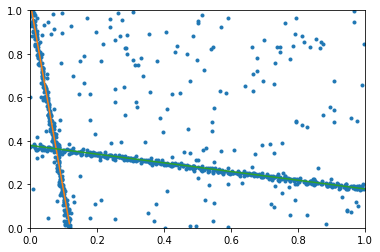

In [14]:
line1 = generate_line(image_size)
line2 = generate_line(image_size)
data = generate_data_multi_line2([line1, line2], image_size, sigma_noise, nbr_inliers, nbr_outliers)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plot_data(data, ax)
plot_line(line1, image_size, ax)
plot_line(line2, image_size, ax)
fig.show()

step =  0
counter =  0
new line
new line
step =  1000
counter =  275
step =  2000
counter =  561
step =  3000
counter =  817
step =  4000
counter =  1107
nbr_lines =  2


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


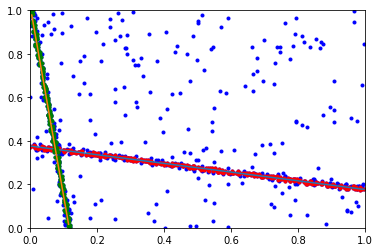

In [15]:
proba = 0.05
threshold = 2.5
threshold_nbr_inliers = 100
threshold_intersection = 20

lines_pred, inliers_pred, nbr_inliers_pred = ransac_uniform_multi(data, threshold, threshold_nbr_inliers, threshold_intersection, image_size, proba)
print("nbr_lines = ", len(lines_pred))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plot_data(data, ax, c='b')
colors = ['r', 'g', 'b']
for i in range(len(inliers_pred)):
    plot_data(change_format(inliers_pred[i]), ax, c=colors[i % 3])
    plot_line(lines_pred[i], image_size, ax)



fig.show()

#### Improved Ransac

In [34]:
def ransac_multi_improved(data, threshold, threshold_nbr_inliers, threshold_intersection, image, proba, type_first_point, type_loss, model_type = None, line_ref=None, model=None, compare=False, it_end=150, n_x=0.05, n_y=0.05):
    step = 0
    inliers_max = []
    nbr_inliers_max = []
    line_max = []
    end = False
    nbr_inliers = []
    n = len(data[0])
    counter = 0
    
    densities = get_density_vector(data, image, n_x, n_y)
    while not end:
        if (step % 10 == 0):
            print("step = ", step)
            print("counter = ", counter)
        line = get_model(model, model_type, data, image, type_loss, type_first_point, line_ref, densities)
        inliers = get_inliers_couple(data, line, threshold, image)
        print(len(inliers))
        if len(inliers) > threshold_nbr_inliers:
            counter += 1
            max_inter = -1
            max_inliers_inter = threshold_intersection*len(inliers) - 1
            for k in range(len(inliers_max)):
                inter = nbr_intersection(inliers, inliers_max[k])
                #print("intersection = ", inter)
                if inter > max_inliers_inter:
                    #print(len(inliers), len(inliers_max[k]))
                    #print(sorted(inliers))
                    #print()
                    #print(sorted(inliers_max[k]))
                    max_inliers_inter = inter
                    max_inter = k
                    
            if max_inter == -1:
                print("new line")
                line_max.append(line)
                inliers_max.append(inliers)
                nbr_inliers_max.append(len(inliers))
            else:
                print("change line", max_inter, ",", "intersection =", max_inliers_inter)
                if len(inliers) > nbr_inliers_max[max_inter]:
                    line_max[max_inter] = line
                    inliers_max[max_inter] = inliers
                    nbr_inliers_max[max_inter] = len(inliers)

        step += 1
        #end = stopping_criterion_multi(step, nbr_inliers_max, n, proba)
        end = (step > it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    return line_max, inliers_max, nbr_inliers_max

step =  0
counter =  0
37
5
104
new line
5
78
46
86
6
14
113
change line 0 , intersection = 74
step =  10
counter =  2
108
change line 0 , intersection = 60
3
5
36
14
84
123
change line 0 , intersection = 90
51
107
change line 0 , intersection = 95
111
change line 0 , intersection = 89
step =  20
counter =  6
14
88
33
121
change line 0 , intersection = 114
17
97
74
103
change line 0 , intersection = 91
86
101
change line 0 , intersection = 76
step =  30
counter =  9
9
6
5
76
37
99
19
12
31
8
step =  40
counter =  9
96
3
118
change line 0 , intersection = 107
104
change line 0 , intersection = 89
46
84
80
12
76
45
step =  50
counter =  11
29
38
72
20
6
5
31
116
change line 0 , intersection = 107
42
107
change line 0 , intersection = 82
step =  60
counter =  13
81
86
113
change line 0 , intersection = 88
105
change line 0 , intersection = 95
51
105
change line 0 , intersection = 81
104
change line 0 , intersection = 78
124
change line 0 , intersection = 109
5
4
step =  70
counter =  18
3

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


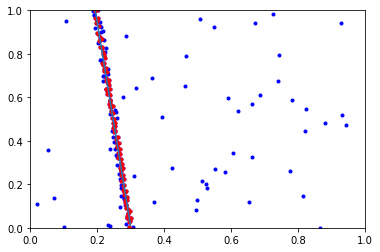

In [35]:
proba = 0.05
threshold = 2.5
threshold_nbr_inliers = 100
threshold_intersection = 0.2

lines_pred, inliers_pred, nbr_inliers_pred = ransac_multi_improved(data, threshold, threshold_nbr_inliers, threshold_intersection, image_size, proba, 0, 1, model_type=1, model=model, it_end=100)
print("nbr_lines = ", len(lines_pred))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plot_data(data, ax, c='b')
colors = ['r', 'g', 'b']
for i in range(len(inliers_pred)):
    plot_data(change_format(inliers_pred[i]), ax, c=colors[i % 3])
    plot_line(lines_pred[i], image_size, ax)



fig.show()

## Multi lines v2

#### Uniform

In [23]:
def stopping_criterion_uniform(step, inliers, total, proba):
    if step < 1000:
        return False
    x = 1 - (inliers/total)**2
    if x**step > proba:
        return False
    return True

def remove_intersection(data, inliers):
    data_update_X = []
    data_update_Y = []
    n = len(data[0])
    for j in range(n):
        (x, y) = data[0][j], data[1][j]
        if (x, y) not in inliers:
            data_update_X.append(x)
            data_update_Y.append(y)
    return (data_update_X, data_update_Y)

def ransac_uniform_multi_v2(data, threshold, threshold_nbr_inliers, image, proba):
    inliers_max_all = []
    nbr_inliers_max_all = []
    line_max_all = []
    nbr_inliers = []
    data_update = data
    finish = False

    while not finish:
        step = 0
        line_max = -1
        nbr_inliers_max = threshold_nbr_inliers
        end = False
        inliers_max = []
        n = len(data_update[0])
        while not end:
            line = get_model_uniform(data_update, image)
            inliers = get_inliers_couple(data_update, line, threshold, image)
            if len(inliers) > nbr_inliers_max:
                line_max = line
                nbr_inliers_max = len(inliers)
                inliers_max = inliers
            step += 1
            end = stopping_criterion_uniform(step, nbr_inliers_max, n, proba)
            
        if line_max == -1:
            finish = True
        else:
            inliers_max_all.append(inliers_max)
            nbr_inliers_max_all.append(nbr_inliers_max)
            line_max_all.append(line_max)
            data_update = remove_intersection(data_update, inliers_max)
            

        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    return line_max_all, inliers_max_all, nbr_inliers_max_all

nbr_lines =  2


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


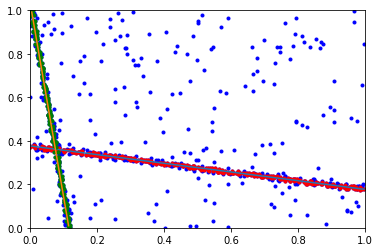

In [25]:
proba = 0.05
threshold = 2.5
threshold_nbr_inliers = 100

lines_pred, inliers_pred, nbr_inliers_pred = ransac_uniform_multi_v2(data, threshold, threshold_nbr_inliers, image_size, proba)
print("nbr_lines = ", len(lines_pred))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plot_data(data, ax, c='b')
colors = ['r', 'g', 'b']
for i in range(len(inliers_pred)):
    plot_data(change_format(inliers_pred[i]), ax, c=colors[i % 3])
    plot_line(lines_pred[i], image_size, ax)



fig.show()

#### Improved Ransac

In [36]:
def ransac_multi_improved_v2(data, threshold, threshold_nbr_inliers, image, proba, type_first_point, type_loss, model_type = None, line_ref=None, model=None, compare=False, it_end=150, n_x=0.05, n_y=0.05):
    inliers_max_all = []
    nbr_inliers_max_all = []
    line_max_all = []
    nbr_inliers = []
    data_update = data
    finish = False

    while not finish:
        step = 0
        densities = get_density_vector(data, image, n_x, n_y)
        line_max = -1
        nbr_inliers_max = threshold_nbr_inliers
        end = False
        inliers_max = []
        n = len(data_update[0])
        while not end:
            line = get_model(model, model_type, data, image, type_loss, type_first_point, line_ref, densities)
            inliers = get_inliers_couple(data, line, threshold, image)
            if len(inliers) > nbr_inliers_max:
                line_max = line
                nbr_inliers_max = len(inliers)
                inliers_max = inliers
            step += 1
            end = (step > it_end)
            
        if line_max == -1:
            finish = True
        else:
            inliers_max_all.append(inliers_max)
            nbr_inliers_max_all.append(nbr_inliers_max)
            line_max_all.append(line_max)
            data_update = remove_intersection(data_update, inliers_max)
            

        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    return line_max_all, inliers_max_all, nbr_inliers_max_all

In [ ]:
proba = 0.05
threshold = 2.5
threshold_nbr_inliers = 100

lines_pred, inliers_pred, nbr_inliers_pred = ransac_multi_improved_v2(data, threshold, threshold_nbr_inliers, image_size, proba, 0, 1, model_type=1, model=model, it_end=100)
print("nbr_lines = ", len(lines_pred))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plot_data(data, ax, c='b')
colors = ['r', 'g', 'b']
for i in range(len(inliers_pred)):
    plot_data(change_format(inliers_pred[i]), ax, c=colors[i % 3])
    plot_line(lines_pred[i], image_size, ax)



fig.show()